In [138]:
import pandas as pd
import numpy as np
import os
import sqlite3
import shutil
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import HTML, display, Markdown
import tabulate
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
import graphviz
from GraphVizUtil import *
from GraphVizFormats import *
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
sb.set(style='darkgrid', font_scale=1.2)

def filter_descriptions(tech_comm_desc):
    try:
        tech_comm_desc = tech_comm_desc.values[0][0].replace('#', '').replace('"','').replace("\n",'').strip()
    except:
        tech_comm_desc = 'No description provided'
    return tech_comm_desc

def create_args_flowd(df_graph):
    nodes, tech, ltech, to_tech, from_tech = set(), set(), set(), set(), set()
    for ind,row in df_graph.iterrows():
        #descriptions:
        input_comm_des = filter_descriptions(pd.read_sql("SELECT comm_desc FROM commodities WHERE comm_name='" + row['input_comm'] + "'", con))
        output_comm_des = filter_descriptions(pd.read_sql("SELECT comm_desc FROM commodities WHERE comm_name='" + row['output_comm'] + "'", con))
        tech_des = filter_descriptions(pd.read_sql("SELECT tech_desc FROM technologies WHERE tech='" + row['tech'] + "'", con))

        if 'ethos' in row['input_comm']:
            ltech.add('"' + row['tech'] + '"' +  ' [tooltip = "' + tech_des + '"]')
        else :
            nodes.add('"' + row['input_comm'] + '"' +  ' [tooltip = "' + input_comm_des + '"]')
        nodes.add('"' + row['output_comm'] + '"' +  ' [tooltip = "' + output_comm_des + '"]')
        tech.add('"' + row['tech'] + '"' +  ' [tooltip = "' + tech_des + '"]')

        if row['input_comm'] != 'ethos':
            to_tech.add('"%s"' % row['input_comm'] + '\t->\t"%s"' % row['tech']) 
        from_tech.add('"%s"' % row['tech'] + '\t->\t"%s"' % row['output_comm'])
    args = dict(
    enodes = "".join('%s;\n\t\t' % x for x in nodes),
    tnodes = "".join('%s;\n\t\t' % x for x in tech),
    iedges = "".join('%s;\n\t\t' % x for x in to_tech),
    oedges = "".join('%s;\n\t\t' % x for x in from_tech),
    snodes = ";".join('%s' %x for x in ltech),
    )
    return args

def return_format_colors():
    colors = {}
    colors.update(getColorConfig(False))
    return colors, quick_run_dot_fmt

def return_flowd_table(final_dem, level=1):
    df = pd.read_sql("SELECT * FROM Efficiency", con)
    df_sel = df[df['output_comm']==final_dem]
    if len(df_sel)==0:
        df_sel = df[df['tech']==final_dem]
    inputs = df_sel['input_comm'].unique()
    iterval=0
    if level!=0:
        while len(inputs)>0:
            df_append = df[df['output_comm'].isin(inputs)]
            df_sel = pd.concat([df_sel, df_append])
            inputs = df_append['input_comm'].unique()
            iterval+=1
            if iterval>level-1:
                break
    df_graph = df_sel[['input_comm', 'tech', 'output_comm']].drop_duplicates()
    return df_graph

def return_flowd_table_fwds(final_dem):
    df = pd.read_sql("SELECT * FROM Efficiency", con)
    df_sel = df[df['output_comm']==final_dem]
    if len(df_sel)==0:
        df_sel = df[df['tech']==final_dem]
    inputs = df_sel['input_comm'].unique()
    outputs = df_sel['output_comm'].unique()

    iterval=0
    while len(inputs)>0:
        df_append = df[df['output_comm'].isin(inputs)]
        df_sel = pd.concat([df_sel, df_append])
        inputs = df_append['input_comm'].unique()
        iterval+=1
        if iterval>2:
            break
    iterval=0
    while len(outputs)>0:
        df_append = df[df['input_comm'].isin(outputs)]
        df_sel = pd.concat([df_sel, df_append])
        outputs = df_append['output_comm'].unique()
        iterval+=1
        if iterval>=0:
            break

    df_graph = df_sel[['input_comm', 'tech', 'output_comm']].drop_duplicates()
    return df_graph

con = sqlite3.connect(r'../US_1R_TS_NG_supply.sqlite') #change path to database
cur = con.cursor()   
con.text_factory = str 

def controls_rows(w):
    controls = HBox(w.children[:-1], layout = Layout(flex_flow='row wrap', width='max-content'))
    output = w.children[-1]
    display(VBox([controls, output],  layout = Layout(flex_flow='columns wrap', width='max-content', size=10)))
    
#https://www.eia.gov/energyexplained/units-and-calculators/
btu_per_oil_bbl = 5698000
PJ_per_oil_bbl = btu_per_oil_bbl*1.05506e-12

# Introduction
The fuel supply sector consists of commodities and technologies that provide refined petroleum products, coal, natural gas and biomass resources to the energy modeling system. These resources are discussed separately in the sections that follow.

## Natural gas
The natural gas sector is characterized by gas production and pipeline transport to the US consuming regions. In the current database, we assume a single region that can supply natural gas that can be transported to the different OEO regions. Note that the current representation is embedded in the single region OEO database (US_1R_TS.sql) and will be added to the 9-region OEO database (US_Regional.sql) soon.

### Natural gas supply
Global natural gas resources are represented by data from 
<a href="https://www.nature.com/articles/s41467-020-17679-3" rel="nofollow">Pye et al. (2020)</a>, specifically from the data reported in the supplementary materials used to develop Supp Figure 20. Natural gas resources are divided into 7 different types as shown in the table below. 

|Code| Crude resource type|
| :--- | :--- |
|1	|Conventional proved reserves|
|2	|Conventional reserve additions|
|3	|Conventional new discovery|
|4	|Arctic|
|5	|Shale gas|
|6	|Tight gas|
|7	|Coal bed methane|

The UCL dataset represents cumulative gas resources across 16 world regions. Here, we only focus on resources in the US, since we assume the US will remain a net exporter of gas given current levels of supply. The figure below shows resource curve for the United States. Each 'step' in the curve refers to a type gas of resource within the US, at a specific supply cost and associated total resource available. Each resource type is split into three different steps with differing costs and resource estimates. Therefore, this resource curve consists of 21 distinct steps, ordered by increasing costs.

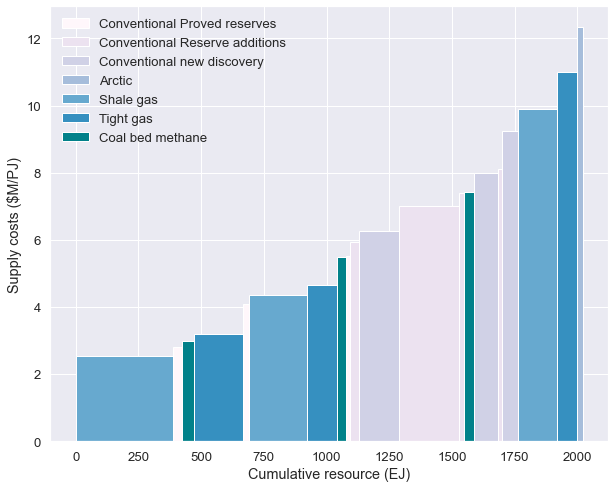

In [139]:
def oil_supply_curve(con):
    df = pd.read_sql("SELECT * FROM MaxResource WHERE regions LIKE 'US%' AND tech LIKE 'IMPGAS%'", con)
    df_costs = pd.read_sql("SELECT * FROM CostVariable WHERE regions LIKE 'US%' AND tech LIKE 'IMPGAS%'", con)
    df = df.merge(df_costs[['regions','tech','periods', 'cost_variable']], on=['regions', 'tech']).drop(columns='periods')
    df = df.drop_duplicates()
    df['maxres'] /=1000

    cb = dict()
    cb['Conventional Proved reserves'] = '#fff7fb'
    cb['Conventional Reserve additions'] = '#ece2f0'
    cb['Conventional new discovery'] = '#d0d1e6'
    cb['Arctic'] = '#a6bddb'
    cb['Shale gas'] = '#67a9cf'
    cb['Tight gas'] = '#3690c0'
    cb['Coal bed methane'] = '#02818a'
    
    res_map = dict()
    res_map['Conventional Proved reserves'] = 1
    res_map['Conventional Reserve additions'] = 2
    res_map['Conventional new discovery'] = 3
    res_map['Arctic'] = 4
    res_map['Shale gas'] = 5
    res_map['Tight gas'] = 6
    res_map['Coal bed methane'] = 7
    
    res_map_rev = dict((v,k) for k, v in res_map.items())

    fig, ax = plt.subplots(figsize=(10,8))
    df_sel = df.copy()
    df_sel.sort_values(by='cost_variable', inplace=True)
    df_sel['maxres'] = df_sel['maxres'].cumsum()
    start =0 
    for ind, row in df_sel.iterrows():
        x = start + (row['maxres']-start)/2
        plt.bar(x, row['cost_variable'] , width=row['maxres']-start, color=cb[row['maxres_notes'].split('_')[1]], \
                label=row['maxres_notes'].split('_')[1])
        start = row['maxres']
    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    labels = [res_map[x] for x in labels]
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    unique.sort(key = lambda x: x[1])
    unique2=[]
    for i in np.arange(len(unique)):
        unique2.append((unique[i][0], res_map_rev[unique[i][1]]))
    ax.legend(*zip(*unique2), frameon=False)

    plt.ylabel('Supply costs ($M/PJ)')
    plt.xlabel('Cumulative resource (EJ)')


oil_supply_curve(con)

#### Limits on annual crude oil production by resource step
Each resource step in the US resource curve is assigned an annual production limit for the first time period of the model horizon. For resource steps that had historic production, this limit was assigned as the maximum of historic production between 2015 and 2020. For all other resource steps, a seed value of 0.1% (0.5% over 5 years) of the cumulative resource in that step was used, based on assumptions in <a href="https://discovery.ucl.ac.uk/id/eprint/1418473/2/131106%20Christophe%20McGlade_PhD%20Thesis.pdf" rel="nofollow">McGlade 2013.</a> These limits can be revisited if further data are made available.

Historic production is assigned to the cheapest resource step for each resource type. For example, while shale gas resources have 3 distinct steps in the resource curve, all historic production in the US assumed to apply to the cheapest (first) step of this resource category. All other steps are assumed to have no historic production and are therefore assigned a seed value of 0.1%

Historic gas production for shale gas, conventional proved reserves, tight gas and coal bed methane were obtained from the <a href="https://www.eia.gov/dnav/ng/ng_prod_sum_dc_NUS_mmcf_a.htm
" rel="nofollow">US EIA</a>. The maximum national historic production values between 2015 and 2020 were used as the annual limits for each resource step and are presented in the table below. 

In [51]:
def growthseed(con):
    df = pd.read_sql("SELECT * FROM GrowthRateSeed WHERE tech LIKE 'IMPGAS_%'", con)
    df.sort_values(by='growthrate_seed', inplace=True, ascending=False)
    df = df.iloc[0:4,:]
    df['growthrate_seed_notes'] = [x.split('_')[1] for x in df['growthrate_seed_notes']]
    header = ['Resource' , 'Maximum historic production (PJ/year)']
    display(HTML(tabulate.tabulate(df[['growthrate_seed_notes', 'growthrate_seed']].set_index('growthrate_seed_notes'), \
                                   header,  floatfmt=".0f" , tablefmt='html')))
growthseed(con)

Resource,Maximum historic production (PJ/year)
Shale gas,30386
Conventional Proved reserves,10253
Tight gas,7153
Coal bed methane,1298


#### Growth rate constraints on annual production

As noted above, maximum annual production for each resource step in the first model time period is constrained to be the maximum historical production value or seed value. Those maximum production rates are relaxed over time using growth rates. Maximum annual growth rate values were assigned to each resource step based on crude oil type, using assumptions outlined in the  <a href="https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-17679-3/MediaObjects/41467_2020_17679_MOESM1_ESM.pdf" rel="nofollow">supplementary information in Pye et al. (2020)</a>, Table 11b.

In [59]:
def regional_growthmax(con):
    df = pd.read_sql("SELECT * FROM GrowthRateMax WHERE tech LIKE 'IMPGAS%'", con)
    df['growthrate_max_notes'] = [x.split('_')[1] for x in df['growthrate_max_notes']]
    df.drop_duplicates(subset=['growthrate_max_notes', 'growthrate_max'], inplace=True)
    df.sort_values(by='growthrate_max', inplace=True)
    header = ['Region' , 'Maximum growth rate']
    display(HTML(tabulate.tabulate(df[['growthrate_max_notes', 'growthrate_max']].set_index('growthrate_max_notes'), \
                                   header,  floatfmt=".2f" , tablefmt='html')))
regional_growthmax(con)

Region,Maximum growth rate
Coal bed methane,1.12
Tight gas,1.12
Arctic,1.12
Shale gas,1.27
Conventional Proved reserves,1.41
Conventional Reserve additions,1.41
Conventional new discovery,1.41


#### Emissions from natural gas supply
The CO2 combustion emissions factor is assumed to be 50 kt/PJ for all natural gas categories, while the upstream emissions are assumed to be 13.8 kt/PJ based on <a href= "https://www.science.org/doi/abs/10.1126/science.aar7204" rel="nofollow">Alvarez et al (2018)</a>.

### Cost adders by energy sector
The resources curves described earlier focus on costs relating to natural gas production only. These costs are typically lower than the market prices seen in each energy sector, and therefore we utilize sector-specific cost-adders to approximately represent natural gas prices in each sector. We approximate the cost adder for each sector as the difference between Henry Hub prices and sector-level natural gas prices projected in the <a href="https://www.eia.gov/outlooks/aeo/data/browser/#/?id=13-AEO2021&cases=ref2021~aeo2020ref&sourcekey=0" rel="nofollow">AEO 2021</a>.

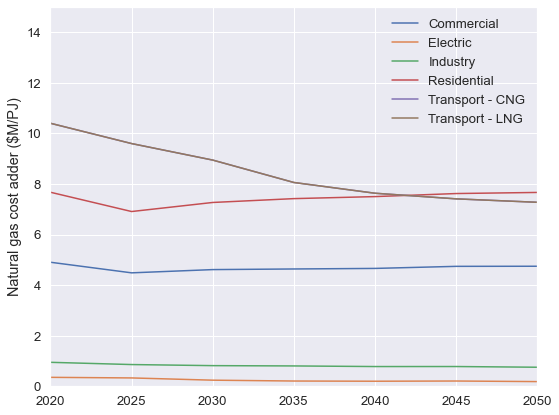

In [140]:
def plot_cost_adders(con):
    techs = dict()
    techs['IMPINDNG'] = 'Industry'
    techs['IMPRESNGA'] = 'Residential'
    techs['IMPCOMNGA'] = 'Commercial'
    techs['IMPELCNGA_S3'] = 'Electric'
    techs['IMPTRNLNG'] = 'Transport - LNG'
    techs['IMPTRNCNG'] = 'Transport - CNG'

    df = pd.read_sql("SELECT * FROM CostVariable WHERE tech IN ('" + "','".join(techs.keys()) + "')", con)
    df_plot = df.pivot_table(values='cost_variable', index='periods', columns='tech')
    df_plot.columns = df_plot.columns.map(techs)
    fig, ax = plt.subplots(figsize=(8,6))
    df_plot.plot(ax=ax)
    plt.legend(frameon=False, loc= 'upper right')
    plt.xlabel('')
    plt.xlim(2020,2050)
    plt.ylim([0, 15])
    plt.ylabel('Natural gas cost adder ($M/PJ)')
    plt.tight_layout()
plot_cost_adders(con)

### Natural gas demand for exports
In 2020, the US imported 2.5 Tcf <a href= "https://www.eia.gov/dnav/ng/ng_move_impc_s1_a.htm" rel="nofollow">(US EIA)</a> and exported 5.2 Tcf <a href= "https://www.eia.gov/dnav/ng/ng_move_expc_s1_a.htm" rel="nofollow">(US EIA)</a>, with net exports of 2.7 Tcf. As a placeholder, this international net exports demand is assumed to remain constant through from 2020 to 2050 in our modeling framework.

# Technology/commodity description lookup tool <a class="anchor" id="description_look_up"></a>
Use the tool below to search for any key words that may describe a technology or commodity of interest (e.g. heating, cooling). The tool provides a list of all the technologies or commodities in the database that may be relevant to the query.


In [141]:
w = widgets.Text(value='natural gas commodity')
display(w)
def f(w):
    if len(w)>0:
        df1 = pd.read_sql("SELECT * FROM commodities WHERE comm_desc LIKE '%" + w + "%'", con)
        df1['desc'] = df1['comm_desc'].str.replace('#','').str.strip()
        df1['comm_tech'] = df1['comm_name']
        df1['type'] = 'commodity'

        df2 = pd.read_sql("SELECT * FROM technologies WHERE tech_desc LIKE '%" + w + "%'", con)
        df2['desc'] = df2['tech_desc'].str.replace('#','').str.strip()
        df2['comm_tech'] = df2['tech']
        df2['type'] = 'technology'


        df = pd.concat([df1[['comm_tech','type','desc']], df2[['comm_tech','type','desc']]])
        
        if len(df)>0:
            display(HTML(tabulate.tabulate(df.set_index('comm_tech'),['technology/commodity','type','description'],stralign='left',tablefmt='html')))
        else:
            print('')
    else:
        print('')
            


out = widgets.interactive_output(f, {'w': w})
display(out)

Text(value='natural gas commodity')

Output()

# Network diagram lookup tool  <a class="anchor" id="network_look_up"></a>
Use the [description lookup tool](#description_look_up) above to identify specific commodity or technology names. Type the name in the box below to generate a corresponding network diagram for that commodity or technology. The slider can be used to view different upstream levels of the network diagram.

In [142]:
w = widgets.Text(value='IMPCOMNGA')
display(w)
def f(w):
    if len(w)>0:
        
        df1 = pd.read_sql("SELECT comm_name, comm_desc FROM commodities WHERE comm_name='" + w + "'", con)
        df1['desc'] = df1['comm_desc'].str.replace('#','').str.strip()
        df1['comm_tech'] = df1['comm_name']
        df1['type'] = 'commodity'

        df2 = pd.read_sql("SELECT * FROM technologies WHERE tech='" + w + "'", con)
        df2['desc'] = df2['tech_desc'].str.replace('#','').str.strip()
        df2['comm_tech'] = df2['tech']
        df2['type'] = 'technology'

        df = pd.concat([df1[['comm_tech','type','desc']], df2[['comm_tech','type','desc']]])

    
        if len(df)>0:
            def show_desc(level):
                display(Markdown(df['desc'][0]))
                final_dem = df['comm_tech'][0]
                df_graph = return_flowd_table(final_dem,level)
                args = create_args_flowd(df_graph)
                colors, quick_run_dot_fmt = return_format_colors()
                args.update(colors)
                #o_str = 'rankdir = "LR" ;'
                #r_str = 'rankdir = "LR" ; \n\t size="8,8";'
                #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
                dot_graph = quick_run_dot_fmt % args
                display(graphviz.Source(dot_graph))
            w2 = widgets.IntSlider(value=1,min=0,max=10,step=1,description='Level:',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
            w = widgets.interactive(show_desc, level=w2)
            controls_rows(w)
        else:
            print('')

    else:
        print('')
            


out = widgets.interactive_output(f, {'w': w})
display(out)

Text(value='IMPCOMNGA')

Output()